In [13]:
import numpy as np
import os
#The six.moves module provides modules under a common name for both Python2 and 3 
import sys
#System-specific parameters and functions. This module provides access 
#to some variables used or maintained by the interpreter and to functions 
#that interact strongly with the interpreter.
import tensorflow as tf
#The zipfile module can be used to manipulate ZIP archive files.
from collections import defaultdict
#defaultdict in contrast will simply create any items that you try
#to access (provided of course they do not exist yet). 
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
#Python Imaging Library class image
sys.path.append("C:/Users/sarva/Tensorflow1/models/research")
from object_detection.utils import ops as utils_ops

In [14]:
%matplotlib inline
from utils import label_map_util
from utils import visualization_utils as vis_utils

In [15]:
model='C:/Users/sarva/Tensorflow1/models/research/object_detection/ssd_mobilenet_v1_coco_2017_11_17'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
frozengraphpath=model+'/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
labelspath=os.path.join('C:/Users/sarva/Tensorflow1/models/research/object_detection/data','mscoco_label_map.pbtxt')

In [16]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(frozengraphpath, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [17]:
category_index=label_map_util.create_category_index_from_labelmap(labelspath,use_display_name=True)

In [18]:
def load_image(image):
    (im_width,im_height)=image.size
    return np.array(image.getdata()).reshape((im_height,im_width,3)).astype(np.uint8)

In [19]:
testimages='C:/Users/sarva'
testimagepath=[os.path.join(testimages,'img{}.jpg'.format(i)) for i in range(2,8)]
IMAGE_SIZE=(15,12)

In [20]:
def run_inference(image,graph):
    with graph.as_default():
        with tf.Session() as sess:
            #Get handles os i/p and o/p tensors
            ops=tf.get_default_graph().get_operations()
            all_tensor_names={output.name for op in ops for output in op.outputs}
            tensor_dict={}
            for key in [
                'num_detections','detection_boxes','detection_scores',
                'detection_classes','detection_masks'
            ]:
                tensor_name= key+ ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key]=tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes=tf.squeeze(tensor_dict['detection_boxes'],[0])
                detection_masks=tf.squeeze(tensor_dict['detection_masks'],[0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection=tf.cast(tensor_dict['num_detections'][0],tf.int32)
                detection_boxes=tf.slice(detection_boxes, [0,0],[real_num_detection,-1])
                detection_masks=tf.slice(detection_masks, [0,0,0],[real_num_detection,-1,-1])
                detection_masks_reframed=utils_ops.reframe_box_masks_to_image_masks(detection_masks,
                                                                                            detection_boxes, 
                                                                                            image.shape[1], 
                                                                                            image.shape[2])
                detection_masks_reframed=tf.cast(tf.greater(detection_masks_reframed,0.5),tf.uint8)
                tensor_dict['detection_masks']=tf.expand_dims(detection_masks_reframed,0)
            image_tensor=tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            output_dict=sess.run(tensor_dict,feed_dict={image_tensor:image})
            output_dict['num_detections']=int(output_dict['num_detections'][0])
            output_dict['detection_classes']=output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes']=output_dict['detection_boxes'][0]
            output_dict['detection_scores']=output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks']=output_dict['detection_masks'][0]
    return output_dict
                        
                        
                        
                    
                

            

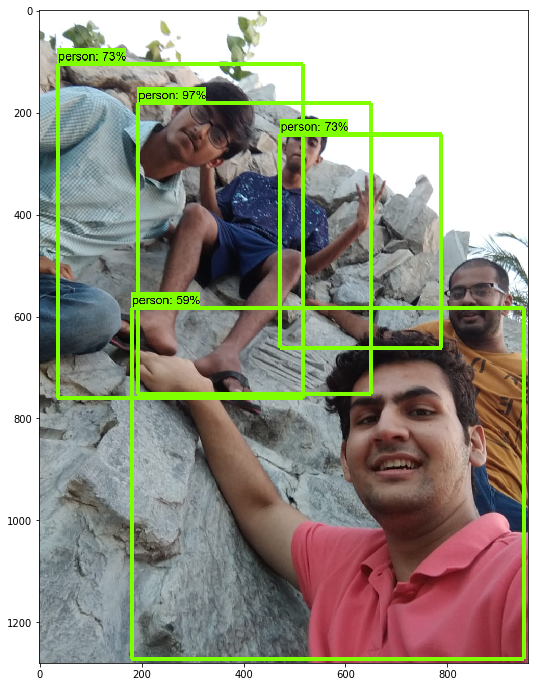

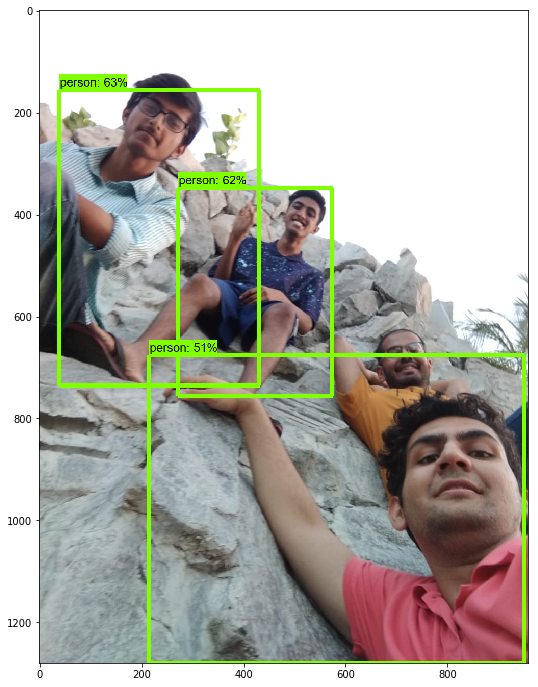

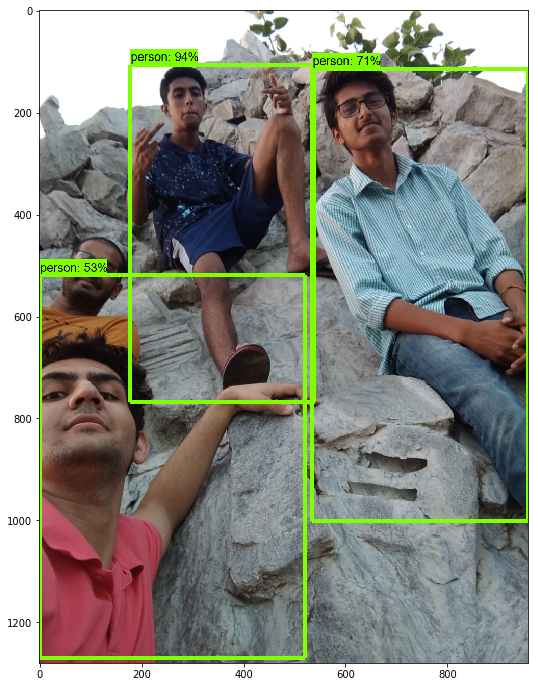

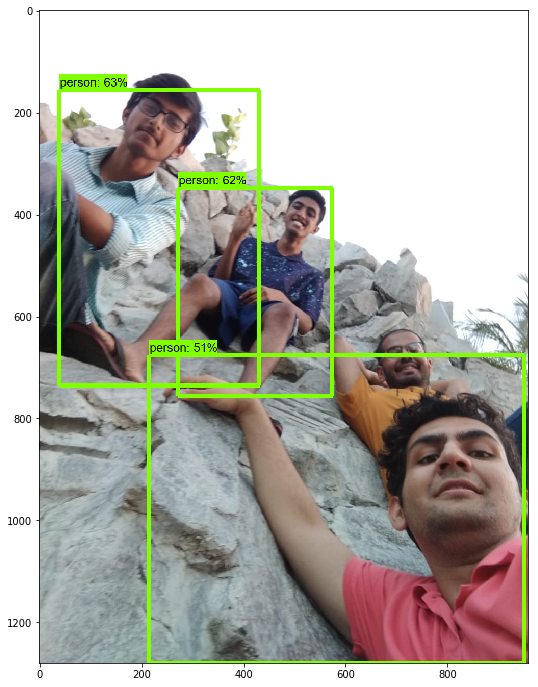

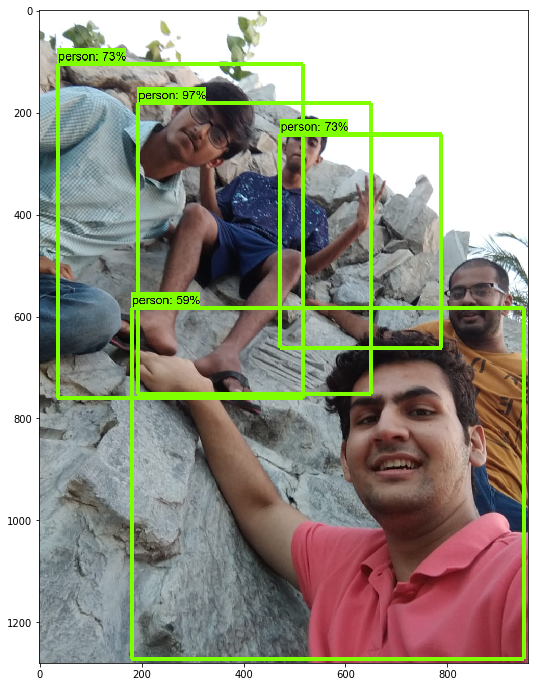

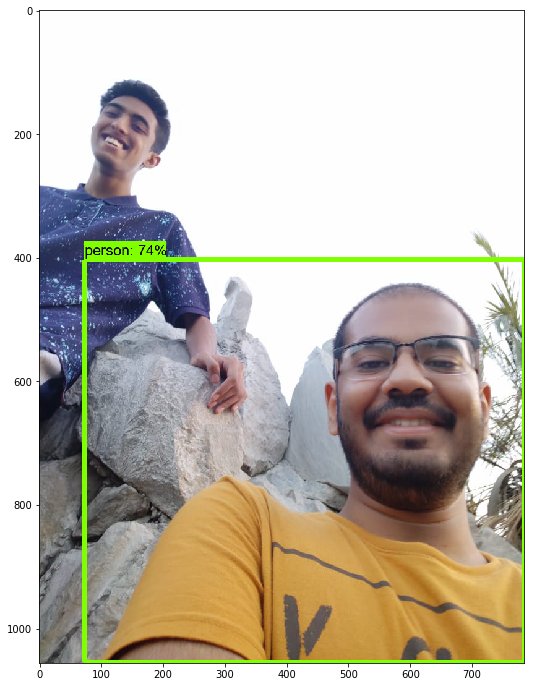

In [21]:
for image_path in testimagepath:
    image = Image.open(image_path)
    image_np=load_image(image)
    image_np_expanded=np.expand_dims(image_np, axis=0)
    output_dict=run_inference(image_np_expanded,detection_graph)
    vis_utils.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)